In [1]:
import pandas as pd
import numpy as np
import openai
import json

# our groupings
seed_hashtags = pd.read_csv("community-grouping_20240809.csv")
# all hashtags double hit
dat = pd.read_csv('double_hits_edges_no_dupes.csv')

# open the secrets file
with open('secrets.json') as f:
    secrets = json.load(f)

api_key = secrets['OPENAI_API_KEY_SR']

client = openai.Client(api_key=api_key)

---
## IRR reliability with human annotation

In [7]:
themes = seed_hashtags.columns[1:]
print(themes)

Index(['cannabis', 'platform', 'cognitive enhancement', 'tobacco/nicotine',
       'drug policy/law', 'Recovery', 'Emotion', 'commonly-misused substances',
       'other substances', 'substance effects', 'consumption method',
       'alcohol', 'Medical/Health Conditions', 'prevention/harm reduction'],
      dtype='object')


In [8]:
hashtag_list = seed_hashtags['Node'].tolist()
print(hashtag_list)

['fyp', 'fypシ', 'fypシ゚viral', 'greenscreen', 'meme', 'tiktok', 'viral', 'trending', 'capcut', 'duet', 'stitch', 'foryou', 'foryoupage', 'foryourpage', 'xyzbca', 'trend', 'love', 'pain', 'addictionhumor', 'funny', 'adtiction', 'addiction', 'stoned', 'high', 'wasted', 'blackedout', 'highasfuck', 'haf', 'shitfaced', 'tipsy', 'drunk', 'hammered', 'blackout', 'substanceabuse', 'substanceusedisorder', 'nootrostatic', 'nootropics', 'smartdrugs', 'smartpills', 'cognitiveenhancers', 'modafinil', 'hightimes', 'opioids', 'opiates', 'heroin', 'fent', 'fentfriday', 'xans', 'xanny', 'xantok', 'xandemic', 'm0lly', 'molly', 'percs', 'percoset', 'perc30s', 'lean', 'leantok', 'acid', 'mescaline', 'pinger', 'pingertok', 'pingtok', 'pingerzzzz', 'emma', 'gurning', 'gurner', 'drank', 'thatdrank', 'bars', '30s', '40s', '512s', 'yellows', 'biak', 'epills', 'psychedelictok', 'lsdart', 'magicmushroomsadventures', 'libcaps', 'libertycapss', 'thom', 'vaping', 'vaper', 'vape', 'ecig', 'ecigs', 'juul', 'cigarettes

In [11]:
def convert_to_tags(input_string):
    # Split the input string into lines
    lines = input_string.strip().split('\n')
    
    # Process each line
    tags = []
    for line in lines:
        # Split each line into words
        words = line.split()
        # Add each word as a tag
        tags.extend(f'{word}' for word in words)
    
    # # Join the tags with commas
    # result = ', '.join(tags)
    
    # Count the total number of tags
    tag_count = len(tags)
    
    return tags, tag_count

# Example input
input_string = """funny	love	adtiction	sobriety	alcohol	weed	cognitiveenhancers	opioids	smoking	druglaws	vitamins	fyp	opioidawareness	stoned	vaping
addictionhumor	pain	addiction	sober	alcoholic	pot	modafinil	opiates	drinking	drugpolicy	suplements	fyp„Ç∑	opioidcrisis	high	vaper
meme	hope	substanceabuse	soberliving	alcoholism	cannabis	nootropics	heroin	drink	pwud	creatine	fyp„Ç∑„Çöviral	overdoseawareness	wasted	vape
	struggle	substanceusedisorder	soberlife	alcoholfreejourney	greens	nootrostatic	fent	shmokesumthin	pwuds	magnesium	greenscreen	overdosecrisis	blackedout	ecig
	kindness	mentalhealth	cleanandsober	beers	stonersoftiktok	smartdrugs	fentfriday	shmoketok		magnesiumglycinate	tiktok	harmreduction	highasfuck	ecigs
	lovemyself	chronicpain	recovery	alchohol	stonervibes	smartpills	xans	shmoke		vitamink	viral	harmreductionworks	haf	juul
	happytobealive	chronicpainsufferers	onedayatatime	vodka	stoner	adderral	xanny	shmoketok		tylenol	trending	harmreductiontips	shitfaced	cigarettes
	trauma	headache	odaat	whiskey	laganjaestranja	addy	xantok	keepsmokingtheherb		disprin	capcut	harmreductionsaveslives	tipsy	cigarette
	loveyall	migraine	na	cocktails	420vibes	cerebrolysin	xandemic	drinkingtools		ayurveda	duet	narcan	drunk	cig
	vibes	addicted	detox	wine	dabs		m0lly	injection		tylenoltuesday	stitch	narcansaveslives	hammered	cigs
	happy	bpd	sobrietybirthday	liquor	wax		molly	injectinguser		ibuprofen	foryou	naloxone	blackout	tobacco
	gratitude	bpdtiktok	soberhouse	tequila	shmeeds		percs	inhaler		coughsyrup	foryoupage	naloxonesaveslives	hightimes	nicotine
	fear	addictionisreal	wedorecover	booze			percoset	inhaling		overthecounter	foryourpage	safesupply	gurning	nicotinefein
	makesomeonesmile	ptsd	relapsehappens	chugbeer			perc30s	keepsmoking		ibuprofeno	xyzbca	endoverdose	gurner	nicotinegum
		depression	methadoneclinic	beerfunnel			lean	inhalation		collagen	trend	overdoseresponse	drunkaf	nicorettepatch
		anxiety	naltrexone	drinkinggames			leantok					opioidaddiction		
		chronicpainwarrior	drugrehab	wildmandrinking			acid					stopsmoking		
		allergy	dropthosedates				mescaline					smokingkills		
		infection	matsaves				pinger					quitnicotine		
		allergies	stopthestigma				pingertok					stopvapping		
		seizures					pingtok					quitvapping		
		epilespy					pingerzzzz							
		depressionandanxiety					emma							
		insomnia					drank							
		fever					thatdrank							
		cough					bars							
		asthma					30s							
		sorethroat					40s							
		flu					512s							
		fluseason					yellows							
		bronchitis					biak							
							epills							
							psychedelictok							
							lsdart							
							magicmushroomsadventures							
							libcaps							
							libertycapss							
							thom							
							nosebeers							
							c0deine							
							inhalants							
							inhalantsaddiction							
							whippets							
							whipit							
							balloons							"""

# Convert and print the result
result, count = convert_to_tags(input_string)
print("Converted tags:")
print(result)
print(f"\nTotal number of tags: {count}")

Converted tags:
['funny', 'love', 'adtiction', 'sobriety', 'alcohol', 'weed', 'cognitiveenhancers', 'opioids', 'smoking', 'druglaws', 'vitamins', 'fyp', 'opioidawareness', 'stoned', 'vaping', 'addictionhumor', 'pain', 'addiction', 'sober', 'alcoholic', 'pot', 'modafinil', 'opiates', 'drinking', 'drugpolicy', 'suplements', 'fyp„Ç∑', 'opioidcrisis', 'high', 'vaper', 'meme', 'hope', 'substanceabuse', 'soberliving', 'alcoholism', 'cannabis', 'nootropics', 'heroin', 'drink', 'pwud', 'creatine', 'fyp„Ç∑„Çöviral', 'overdoseawareness', 'wasted', 'vape', 'struggle', 'substanceusedisorder', 'soberlife', 'alcoholfreejourney', 'greens', 'nootrostatic', 'fent', 'shmokesumthin', 'pwuds', 'magnesium', 'greenscreen', 'overdosecrisis', 'blackedout', 'ecig', 'kindness', 'mentalhealth', 'cleanandsober', 'beers', 'stonersoftiktok', 'smartdrugs', 'fentfriday', 'shmoketok', 'magnesiumglycinate', 'tiktok', 'harmreduction', 'highasfuck', 'ecigs', 'lovemyself', 'chronicpain', 'recovery', 'alchohol', 'stonervib

In [2]:
all_human_tags_string = """
30s
40s
420vibes
512s
acid
adderral
addicted
addiction
addictionhumor
addictionisreal
addy
adtiction
alchohol
alcohol
alcoholfreejourney
alcoholic
alcoholism
allergies
allergy
anxiety
asthma
ayurveda
balloons
bars
beerfunnel
beers
biak
blackedout
blackout
booze
bpd
bpdtiktok
bronchitis
c0deine
cannabis
capcut
cerebrolysin
chronicpain
chronicpainsufferers
chronicpainwarrior
chugbeer
cig
cigarette
cigarettes
cigs
cleanandsober
cocktails
cognitiveenhancers
collagen
cough
coughsyrup
creatine
dabs
depression
depressionandanxiety
detox
disprin
drank
drink
drinking
drinkinggames
drinkingtools
dropthosedates
druglaws
drugpolicy
drugrehab
drunk
drunkaf
duet
ecig
ecigs
emma
endoverdose
epilespy
epills
fear
fent
fentfriday
fever
flu
fluseason
foryou
foryoupage
foryourpage
funny
fyp
fyp„Ç∑
fyp„Ç∑„Çöviral
gratitude
greens
greenscreen
gurner
gurning
haf
hammered
happy
happytobealive
harmreduction
harmreductionsaveslives
harmreductiontips
harmreductionworks
headache
heroin
high
highasfuck
hightimes
hope
ibuprofen
ibuprofeno
infection
inhalants
inhalantsaddiction
inhalation
inhaler
inhaling
injectinguser
injection
insomnia
juul
keepsmoking
keepsmokingtheherb
kindness
laganjaestranja
lean
leantok
libcaps
libertycapss
liquor
love
lovemyself
loveyall
lsdart
m0lly
magicmushroomsadventures
magnesium
magnesiumglycinate
makesomeonesmile
matsaves
meme
mentalhealth
mescaline
methadoneclinic
migraine
modafinil
molly
na
naloxone
naloxonesaveslives
naltrexone
narcan
narcansaveslives
nicorettepatch
nicotine
nicotinefein
nicotinegum
nootropics
nootrostatic
nosebeers
odaat
onedayatatime
opiates
opioidaddiction
opioidawareness
opioidcrisis
opioids
overdoseawareness
overdosecrisis
overdoseresponse
overthecounter
pain
perc30s
percoset
percs
pinger
pingertok
pingerzzzz
pingtok
pot
psychedelictok
ptsd
pwud
pwuds
quitnicotine
quitvapping
recovery
relapsehappens
safesupply
seizures
shitfaced
shmeeds
shmoke
shmokesumthin
shmoketok
smartdrugs
smartpills
smoking
smokingkills
sober
soberhouse
soberlife
soberliving
sobriety
sobrietybirthday
sorethroat
stitch
stoned
stoner
stonersoftiktok
stonervibes
stopsmoking
stopthestigma
stopvapping
struggle
substanceabuse
substanceusedisorder
suplements
tequila
thatdrank
thom
tiktok
tipsy
tobacco
trauma
trend
trending
tylenol
tylenoltuesday
vape
vaper
vaping
vibes
viral
vitamink
vitamins
vodka
wasted
wax
wedorecover
weed
whipit
whippets
whiskey
wildmandrinking
wine
xandemic
xanny
xans
xantok
xyzbca
yellows"""
all_human_tags = [tag.strip() for tag in all_human_tags_string.split('\n') if tag.strip()]
print(len(all_human_tags))

250


In [3]:
from collections import Counter

# Assuming all_human_tags is your list of tags
tag_counts = Counter(all_human_tags)

# Find duplicates (tags that appear more than once)
duplicates = [tag for tag, count in tag_counts.items() if count > 1]

if duplicates:
    print("Duplicate tags found:")
    for tag in duplicates:
        print(f"{tag}: {tag_counts[tag]} occurrences")
else:
    print("No duplicate tags found.")

No duplicate tags found.


In [4]:
prompt_template = """"
Instruction: You are an expert linguist, specializing in content related to substances and drug use. Your task is to semantically categorize phrase or hashtag from TikTok that have been associated with drug-related content. Here are the 15 defined categories:

Cannabis: Content related to marijuana, including recreational and medicinal use.
Platform Engagement: Tags and features specific to social media engagement, visibility, and trending tactics.
Cognitive Enhancement: Content about nootropics, smart drugs, and methods to improve cognitive function.
Tobacco/Nicotine: Topics related to tobacco products, cigarettes, vaping, and nicotine use.
Drug Policy/Law: Discussions about drug laws, policies, and related social issues.
Recovery: Content about addiction recovery, sobriety, and support systems.
Emotion: Tags related to emotional states.
Humor: Tags related to humorous content.
commonly-misused substances: Recognize references to frequently abused drugs, including slang terms and euphemisms.
Other Substances: Mentions of less common substances, oftentimes legal, over-the-counter medications, herbal remedies, or supplements.
Substance Effects: Tags related to physical or mental effects of substance use. This includes both desired effects and side effects.
Consumption Method: Specific ways in which substances are ingested, administered, or used.
Alcohol: Content related to alcohol consumption and its effects
Medical/Health Conditions: Themes about health issues directly related to substance use, addiction-related health problems, or chronic conditions that may lead to substance use. Tags related to health issues stemming from substance use or conditions that might lead to substance use.
Prevention/Harm Reduction: Information and strategies to prevent substance abuse or reduce associated harm

Task: Categorize the hashtag provided below into exactly one of the 15 categories: Humor, Emotion, Medical/Health Conditions,Recovery,Alcohol, cannabis, cognitive enhancement, commonly-misused substances, consumption method, drug policy/law, other substances, platform, prevention/harm reduction, substance effects, tobacco/nicotine. Do not make new categories and only use the ones provided to you. Do not change any spellings of the hashtag or categories. Do not give me any explanations. Present your results in a clear, organized format, listing the hashtag followed by its assigned category: "Hashtag: (the predicted hashtag), Category: (the predicted category)"

Hashtag: {hashtag}
"""

In [5]:
from tqdm import tqdm

def classify_hashtag(hashtag, client, model):
    prompt = prompt_template.format(hashtag=hashtag)
    response = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": prompt
            }
        ],
        model=model,
        temperature=0
    )
    return response.choices[0].message.content.strip()

# Get the list of hashtags
hashtags = all_human_tags

# Initialize a dictionary to store results
results = {}

# Classify each hashtag
for hashtag in tqdm(hashtags, desc="Classifying hashtags", unit="hashtag"):
    classification = classify_hashtag(hashtag, client, "gpt-4o")
    results[hashtag] = classification
    print(classification)


# Convert results to a DataFrame
df_results = pd.DataFrame.from_dict(results, orient='index', columns=['Category'])
df_results.index.name = 'Hashtag'
df_results.reset_index(inplace=True)

# Save results to CSV
df_results.to_csv('gpt_hashtag_classifications_4o.csv', index=False)
print("Classifications saved to gpt_hashtag_classifications.csv")

# Display the first few results
print(df_results.head())

Classifying hashtags:   0%|          | 1/250 [00:01<05:12,  1.26s/hashtag]

Hashtag: 30s, Category: Emotion


Classifying hashtags:   1%|          | 2/250 [00:02<05:32,  1.34s/hashtag]

Hashtag: 40s, Category: Alcohol


Classifying hashtags:   1%|          | 3/250 [00:03<03:46,  1.09hashtag/s]

Hashtag: 420vibes, Category: Cannabis


Classifying hashtags:   2%|▏         | 4/250 [00:03<03:04,  1.33hashtag/s]

Hashtag: 512s, Category: commonly-misused substances


Classifying hashtags:   2%|▏         | 5/250 [00:04<03:36,  1.13hashtag/s]

Hashtag: acid, Category: commonly-misused substances


Classifying hashtags:   2%|▏         | 6/250 [00:05<03:13,  1.26hashtag/s]

Hashtag: adderral, Category: commonly-misused substances


Classifying hashtags:   3%|▎         | 7/250 [00:05<02:58,  1.36hashtag/s]

Hashtag: addicted, Category: Medical/Health Conditions


Classifying hashtags:   3%|▎         | 8/250 [00:06<02:43,  1.48hashtag/s]

Hashtag: addiction, Category: Medical/Health Conditions


Classifying hashtags:   4%|▎         | 9/250 [00:06<02:27,  1.63hashtag/s]

Hashtag: addictionhumor, Category: Humor


Classifying hashtags:   4%|▍         | 10/250 [00:07<02:20,  1.71hashtag/s]

Hashtag: addictionisreal, Category: Medical/Health Conditions


Classifying hashtags:   4%|▍         | 11/250 [00:08<02:21,  1.69hashtag/s]

Hashtag: addy, Category: commonly-misused substances


Classifying hashtags:   5%|▍         | 12/250 [00:08<02:22,  1.67hashtag/s]

Hashtag: adtiction, Category: commonly-misused substances


Classifying hashtags:   5%|▌         | 13/250 [00:09<02:22,  1.66hashtag/s]

Hashtag: alchohol, Category: Alcohol


Classifying hashtags:   6%|▌         | 14/250 [00:09<02:15,  1.74hashtag/s]

Hashtag: alcohol, Category: Alcohol


Classifying hashtags:   6%|▌         | 15/250 [00:10<02:10,  1.80hashtag/s]

Hashtag: alcoholfreejourney, Category: Recovery


Classifying hashtags:   6%|▋         | 16/250 [00:10<02:06,  1.84hashtag/s]

Hashtag: alcoholic, Category: Alcohol


Classifying hashtags:   7%|▋         | 17/250 [00:11<01:57,  1.99hashtag/s]

Hashtag: alcoholism, Category: Alcohol


Classifying hashtags:   7%|▋         | 18/250 [00:11<01:56,  1.99hashtag/s]

Hashtag: allergies, Category: Medical/Health Conditions


Classifying hashtags:   8%|▊         | 19/250 [00:12<01:57,  1.97hashtag/s]

Hashtag: allergy, Category: Medical/Health Conditions


Classifying hashtags:   8%|▊         | 20/250 [00:12<02:04,  1.85hashtag/s]

Hashtag: anxiety, Category: Medical/Health Conditions


Classifying hashtags:   8%|▊         | 21/250 [00:13<02:01,  1.88hashtag/s]

Hashtag: asthma, Category: Medical/Health Conditions


Classifying hashtags:   9%|▉         | 22/250 [00:14<02:06,  1.80hashtag/s]

Hashtag: ayurveda, Category: Other Substances


Classifying hashtags:   9%|▉         | 23/250 [00:14<02:00,  1.89hashtag/s]

Hashtag: balloons, Category: commonly-misused substances


Classifying hashtags:  10%|▉         | 24/250 [00:15<02:01,  1.86hashtag/s]

Hashtag: bars, Category: commonly-misused substances


Classifying hashtags:  10%|█         | 25/250 [00:15<01:59,  1.88hashtag/s]

Hashtag: beerfunnel, Category: Alcohol


Classifying hashtags:  10%|█         | 26/250 [00:16<01:57,  1.91hashtag/s]

Hashtag: beers, Category: Alcohol


Classifying hashtags:  11%|█         | 27/250 [00:16<02:03,  1.81hashtag/s]

Hashtag: biak, Category: other substances


Classifying hashtags:  11%|█         | 28/250 [00:17<02:06,  1.75hashtag/s]

Hashtag: blackedout, Category: Alcohol


Classifying hashtags:  12%|█▏        | 29/250 [00:17<02:02,  1.81hashtag/s]

Hashtag: blackout, Category: Alcohol


Classifying hashtags:  12%|█▏        | 30/250 [00:18<01:59,  1.85hashtag/s]

Hashtag: booze, Category: Alcohol


Classifying hashtags:  12%|█▏        | 31/250 [00:18<01:59,  1.84hashtag/s]

Hashtag: bpd, Category: Medical/Health Conditions


Classifying hashtags:  13%|█▎        | 32/250 [00:19<02:11,  1.66hashtag/s]

Hashtag: bpdtiktok, Category: Medical/Health Conditions


Classifying hashtags:  13%|█▎        | 33/250 [00:20<02:07,  1.71hashtag/s]

Hashtag: bronchitis, Category: Medical/Health Conditions


Classifying hashtags:  14%|█▎        | 34/250 [00:20<02:04,  1.73hashtag/s]

Hashtag: c0deine, Category: commonly-misused substances


Classifying hashtags:  14%|█▍        | 35/250 [00:21<01:57,  1.83hashtag/s]

Hashtag: cannabis, Category: cannabis


Classifying hashtags:  14%|█▍        | 36/250 [00:21<01:54,  1.87hashtag/s]

Hashtag: capcut, Category: Platform Engagement


Classifying hashtags:  15%|█▍        | 37/250 [00:22<01:52,  1.89hashtag/s]

Hashtag: cerebrolysin, Category: cognitive enhancement


Classifying hashtags:  15%|█▌        | 38/250 [00:22<02:04,  1.71hashtag/s]

Hashtag: chronicpain, Category: Medical/Health Conditions


Classifying hashtags:  16%|█▌        | 39/250 [00:23<01:55,  1.83hashtag/s]

Hashtag: chronicpainsufferers, Category: Medical/Health Conditions


Classifying hashtags:  16%|█▌        | 40/250 [00:23<01:48,  1.94hashtag/s]

Hashtag: chronicpainwarrior, Category: Medical/Health Conditions


Classifying hashtags:  16%|█▋        | 41/250 [00:24<01:41,  2.05hashtag/s]

Hashtag: chugbeer, Category: Alcohol


Classifying hashtags:  17%|█▋        | 42/250 [00:24<01:41,  2.06hashtag/s]

Hashtag: cig, Category: tobacco/nicotine


Classifying hashtags:  17%|█▋        | 43/250 [00:25<01:52,  1.84hashtag/s]

Hashtag: cigarette, Category: tobacco/nicotine


Classifying hashtags:  18%|█▊        | 44/250 [00:25<01:48,  1.90hashtag/s]

Hashtag: cigarettes, Category: tobacco/nicotine


Classifying hashtags:  18%|█▊        | 45/250 [00:29<04:55,  1.44s/hashtag]

Hashtag: cigs, Category: tobacco/nicotine


Classifying hashtags:  18%|█▊        | 46/250 [00:29<03:57,  1.16s/hashtag]

Hashtag: cleanandsober, Category: Recovery


Classifying hashtags:  19%|█▉        | 47/250 [00:30<03:15,  1.04hashtag/s]

Hashtag: cocktails, Category: Alcohol


Classifying hashtags:  19%|█▉        | 48/250 [00:31<02:51,  1.18hashtag/s]

Hashtag: cognitiveenhancers, Category: cognitive enhancement


Classifying hashtags:  20%|█▉        | 49/250 [00:31<02:28,  1.36hashtag/s]

Hashtag: collagen, Category: Other Substances


Classifying hashtags:  20%|██        | 50/250 [00:31<02:05,  1.59hashtag/s]

Hashtag: cough, Category: Medical/Health Conditions


Classifying hashtags:  20%|██        | 51/250 [00:32<02:00,  1.65hashtag/s]

Hashtag: coughsyrup, Category: commonly-misused substances


Classifying hashtags:  21%|██        | 52/250 [00:32<01:53,  1.75hashtag/s]

Hashtag: creatine, Category: other substances


Classifying hashtags:  21%|██        | 53/250 [00:33<01:46,  1.84hashtag/s]

Hashtag: dabs, Category: Consumption Method


Classifying hashtags:  22%|██▏       | 54/250 [00:33<01:41,  1.93hashtag/s]

Hashtag: depression, Category: Medical/Health Conditions


Classifying hashtags:  22%|██▏       | 55/250 [00:34<01:43,  1.89hashtag/s]

Hashtag: depressionandanxiety, Category: Medical/Health Conditions


Classifying hashtags:  22%|██▏       | 56/250 [00:34<01:39,  1.94hashtag/s]

Hashtag: detox, Category: prevention/harm reduction


Classifying hashtags:  23%|██▎       | 57/250 [00:35<01:42,  1.89hashtag/s]

Hashtag: disprin, Category: other substances


Classifying hashtags:  23%|██▎       | 58/250 [00:36<01:42,  1.88hashtag/s]

Hashtag: drank, Category: Alcohol


Classifying hashtags:  24%|██▎       | 59/250 [00:36<01:36,  1.98hashtag/s]

Hashtag: drink, Category: Alcohol


Classifying hashtags:  24%|██▍       | 60/250 [00:36<01:31,  2.07hashtag/s]

Hashtag: drinking, Category: Alcohol


Classifying hashtags:  24%|██▍       | 61/250 [00:37<01:32,  2.04hashtag/s]

Hashtag: drinkinggames, Category: Alcohol


Classifying hashtags:  25%|██▍       | 62/250 [00:37<01:30,  2.08hashtag/s]

Hashtag: drinkingtools, Category: Alcohol


Classifying hashtags:  25%|██▌       | 63/250 [00:38<01:29,  2.09hashtag/s]

Hashtag: dropthosedates, Category: platform


Classifying hashtags:  26%|██▌       | 64/250 [00:38<01:33,  2.00hashtag/s]

Hashtag: druglaws, Category: drug policy/law


Classifying hashtags:  26%|██▌       | 65/250 [00:39<01:26,  2.15hashtag/s]

Hashtag: drugpolicy, Category: Drug Policy/Law


Classifying hashtags:  26%|██▋       | 66/250 [00:39<01:26,  2.13hashtag/s]

Hashtag: drugrehab, Category: Recovery


Classifying hashtags:  27%|██▋       | 67/250 [00:40<01:20,  2.27hashtag/s]

Hashtag: drunk, Category: Alcohol


Classifying hashtags:  27%|██▋       | 68/250 [00:40<01:21,  2.24hashtag/s]

Hashtag: drunkaf, Category: Alcohol


Classifying hashtags:  28%|██▊       | 69/250 [00:41<01:19,  2.27hashtag/s]

Hashtag: duet, Category: Platform Engagement


Classifying hashtags:  28%|██▊       | 70/250 [00:41<01:24,  2.12hashtag/s]

Hashtag: ecig, Category: tobacco/nicotine


Classifying hashtags:  28%|██▊       | 71/250 [00:42<01:23,  2.15hashtag/s]

Hashtag: ecigs, Category: Tobacco/Nicotine


Classifying hashtags:  29%|██▉       | 72/250 [00:42<01:26,  2.06hashtag/s]

Hashtag: emma, Category: commonly-misused substances


Classifying hashtags:  29%|██▉       | 73/250 [00:42<01:23,  2.12hashtag/s]

Hashtag: endoverdose, Category: Prevention/Harm Reduction


Classifying hashtags:  30%|██▉       | 74/250 [00:43<01:30,  1.96hashtag/s]

Hashtag: epilespy, Category: Medical/Health Conditions


Classifying hashtags:  30%|███       | 75/250 [00:44<01:30,  1.94hashtag/s]

Hashtag: epills, Category: commonly-misused substances


Classifying hashtags:  30%|███       | 76/250 [00:44<01:27,  1.99hashtag/s]

Hashtag: fear, Category: Emotion


Classifying hashtags:  31%|███       | 77/250 [00:45<01:24,  2.04hashtag/s]

Hashtag: fent, Category: commonly-misused substances


Classifying hashtags:  31%|███       | 78/250 [00:45<01:26,  2.00hashtag/s]

Hashtag: fentfriday, Category: commonly-misused substances


Classifying hashtags:  32%|███▏      | 79/250 [00:46<01:35,  1.79hashtag/s]

Hashtag: fever, Category: Medical/Health Conditions


Classifying hashtags:  32%|███▏      | 80/250 [00:46<01:27,  1.95hashtag/s]

Hashtag: flu, Category: Medical/Health Conditions


Classifying hashtags:  32%|███▏      | 81/250 [00:47<01:31,  1.84hashtag/s]

Hashtag: fluseason, Category: Medical/Health Conditions


Classifying hashtags:  33%|███▎      | 82/250 [00:47<01:25,  1.96hashtag/s]

Hashtag: foryou, Category: Platform Engagement


Classifying hashtags:  33%|███▎      | 83/250 [00:48<01:24,  1.98hashtag/s]

Hashtag: foryoupage, Category: Platform Engagement


Classifying hashtags:  34%|███▎      | 84/250 [00:48<01:29,  1.86hashtag/s]

Hashtag: foryourpage, Category: Platform Engagement


Classifying hashtags:  34%|███▍      | 85/250 [00:49<01:27,  1.89hashtag/s]

Hashtag: funny, Category: Humor


Classifying hashtags:  34%|███▍      | 86/250 [00:49<01:24,  1.94hashtag/s]

Hashtag: fyp, Category: Platform Engagement


Classifying hashtags:  35%|███▍      | 87/250 [00:50<01:25,  1.91hashtag/s]

Hashtag: fyp, Category: Platform Engagement


Classifying hashtags:  35%|███▌      | 88/250 [00:51<01:34,  1.72hashtag/s]

Hashtag: fyp„Ç∑„Çöviral, Category: Platform Engagement


Classifying hashtags:  36%|███▌      | 89/250 [00:51<01:30,  1.79hashtag/s]

Hashtag: gratitude, Category: Emotion


Classifying hashtags:  36%|███▌      | 90/250 [00:52<01:27,  1.83hashtag/s]

Hashtag: greens, Category: cannabis


Classifying hashtags:  36%|███▋      | 91/250 [00:52<01:33,  1.71hashtag/s]

Hashtag: greenscreen, Category: Platform Engagement


Classifying hashtags:  37%|███▋      | 92/250 [00:53<01:30,  1.74hashtag/s]

Hashtag: gurner, Category: commonly-misused substances


Classifying hashtags:  37%|███▋      | 93/250 [00:53<01:27,  1.80hashtag/s]

Hashtag: gurning, Category: substance effects


Classifying hashtags:  38%|███▊      | 94/250 [00:54<01:29,  1.74hashtag/s]

Hashtag: haf, Category: Humor


Classifying hashtags:  38%|███▊      | 95/250 [00:59<05:04,  1.97s/hashtag]

Hashtag: hammered, Category: Alcohol


Classifying hashtags:  38%|███▊      | 96/250 [01:00<04:17,  1.67s/hashtag]

Hashtag: happy, Category: Emotion


Classifying hashtags:  39%|███▉      | 97/250 [01:01<03:24,  1.34s/hashtag]

Hashtag: happytobealive, Category: Emotion


Classifying hashtags:  39%|███▉      | 98/250 [01:01<02:45,  1.09s/hashtag]

Hashtag: harmreduction, Category: Prevention/Harm Reduction


Classifying hashtags:  40%|███▉      | 99/250 [01:02<02:22,  1.06hashtag/s]

Hashtag: harmreductionsaveslives, Category: Prevention/Harm Reduction


Classifying hashtags:  40%|████      | 100/250 [01:02<02:04,  1.20hashtag/s]

Hashtag: harmreductiontips, Category: Prevention/Harm Reduction


Classifying hashtags:  40%|████      | 101/250 [01:03<01:51,  1.33hashtag/s]

Hashtag: harmreductionworks, Category: Prevention/Harm Reduction


Classifying hashtags:  41%|████      | 102/250 [01:04<01:43,  1.43hashtag/s]

Hashtag: headache, Category: Medical/Health Conditions


Classifying hashtags:  41%|████      | 103/250 [01:04<01:34,  1.56hashtag/s]

Hashtag: heroin, Category: commonly-misused substances


Classifying hashtags:  42%|████▏     | 104/250 [01:05<01:29,  1.62hashtag/s]

Hashtag: high, Category: Substance Effects


Classifying hashtags:  42%|████▏     | 105/250 [01:05<01:23,  1.74hashtag/s]

Hashtag: highasfuck, Category: Substance Effects


Classifying hashtags:  42%|████▏     | 106/250 [01:06<01:25,  1.68hashtag/s]

Hashtag: hightimes, Category: cannabis


Classifying hashtags:  43%|████▎     | 107/250 [01:06<01:17,  1.85hashtag/s]

Hashtag: hope, Category: Emotion


Classifying hashtags:  43%|████▎     | 108/250 [01:07<01:38,  1.45hashtag/s]

Hashtag: ibuprofen, Category: Other Substances


Classifying hashtags:  44%|████▎     | 109/250 [01:08<01:29,  1.58hashtag/s]

Hashtag: ibuprofeno, Category: other substances


Classifying hashtags:  44%|████▍     | 110/250 [01:08<01:18,  1.78hashtag/s]

Hashtag: infection, Category: Medical/Health Conditions


Classifying hashtags:  44%|████▍     | 111/250 [01:09<01:14,  1.86hashtag/s]

Hashtag: inhalants, Category: commonly-misused substances


Classifying hashtags:  45%|████▍     | 112/250 [01:09<01:13,  1.88hashtag/s]

Hashtag: inhalantsaddiction, Category: commonly-misused substances


Classifying hashtags:  45%|████▌     | 113/250 [01:10<01:09,  1.97hashtag/s]

Hashtag: inhalation, Category: consumption method


Classifying hashtags:  46%|████▌     | 114/250 [01:10<01:06,  2.03hashtag/s]

Hashtag: inhaler, Category: other substances


Classifying hashtags:  46%|████▌     | 115/250 [01:11<01:09,  1.95hashtag/s]

Hashtag: inhaling, Category: consumption method


Classifying hashtags:  46%|████▋     | 116/250 [01:11<01:12,  1.84hashtag/s]

Hashtag: injectinguser, Category: consumption method


Classifying hashtags:  47%|████▋     | 117/250 [01:12<01:15,  1.77hashtag/s]

Hashtag: injection, Category: consumption method


Classifying hashtags:  47%|████▋     | 118/250 [01:12<01:08,  1.92hashtag/s]

Hashtag: insomnia, Category: Medical/Health Conditions


Classifying hashtags:  48%|████▊     | 119/250 [01:13<01:15,  1.73hashtag/s]

Hashtag: juul, Category: tobacco/nicotine


Classifying hashtags:  48%|████▊     | 120/250 [01:14<01:16,  1.70hashtag/s]

Hashtag: keepsmoking, Category: Tobacco/Nicotine


Classifying hashtags:  48%|████▊     | 121/250 [01:14<01:20,  1.60hashtag/s]

Hashtag: keepsmokingtheherb, Category: cannabis


Classifying hashtags:  49%|████▉     | 122/250 [01:15<01:15,  1.69hashtag/s]

Hashtag: kindness, Category: Emotion


Classifying hashtags:  49%|████▉     | 123/250 [01:16<01:23,  1.51hashtag/s]

Hashtag: laganjaestranja, Category: Cannabis


Classifying hashtags:  50%|████▉     | 124/250 [01:19<03:13,  1.53s/hashtag]

Hashtag: lean, Category: commonly-misused substances


Classifying hashtags:  50%|█████     | 125/250 [01:20<02:33,  1.23s/hashtag]

Hashtag: leantok, Category: commonly-misused substances


Classifying hashtags:  50%|█████     | 126/250 [01:20<02:05,  1.01s/hashtag]

Hashtag: libcaps, Category: other substances


Classifying hashtags:  51%|█████     | 127/250 [01:21<01:50,  1.12hashtag/s]

Hashtag: libertycapss, Category: commonly-misused substances


Classifying hashtags:  51%|█████     | 128/250 [01:22<01:57,  1.04hashtag/s]

Hashtag: liquor, Category: Alcohol


Classifying hashtags:  52%|█████▏    | 129/250 [01:22<01:40,  1.21hashtag/s]

Hashtag: love, Category: Emotion


Classifying hashtags:  52%|█████▏    | 130/250 [01:23<01:28,  1.36hashtag/s]

Hashtag: lovemyself, Category: Emotion


Classifying hashtags:  52%|█████▏    | 131/250 [01:24<01:23,  1.43hashtag/s]

Hashtag: loveyall, Category: Emotion


Classifying hashtags:  53%|█████▎    | 132/250 [01:24<01:19,  1.49hashtag/s]

Hashtag: lsdart, Category: commonly-misused substances


Classifying hashtags:  53%|█████▎    | 133/250 [01:25<01:13,  1.60hashtag/s]

Hashtag: m0lly, Category: commonly-misused substances


Classifying hashtags:  54%|█████▎    | 134/250 [01:25<01:09,  1.66hashtag/s]

Hashtag: magicmushroomsadventures, Category: commonly-misused substances


Classifying hashtags:  54%|█████▍    | 135/250 [01:28<02:12,  1.15s/hashtag]

Hashtag: magnesium, Category: other substances


Classifying hashtags:  54%|█████▍    | 136/250 [01:28<01:48,  1.05hashtag/s]

Hashtag: magnesiumglycinate, Category: Other Substances


Classifying hashtags:  55%|█████▍    | 137/250 [01:29<01:29,  1.26hashtag/s]

Hashtag: makesomeonesmile, Category: Emotion


Classifying hashtags:  55%|█████▌    | 138/250 [01:29<01:19,  1.41hashtag/s]

Hashtag: matsaves, Category: Recovery


Classifying hashtags:  56%|█████▌    | 139/250 [01:30<01:12,  1.54hashtag/s]

Hashtag: meme, Category: Humor


Classifying hashtags:  56%|█████▌    | 140/250 [01:30<01:03,  1.73hashtag/s]

Hashtag: mentalhealth, Category: Medical/Health Conditions


Classifying hashtags:  56%|█████▋    | 141/250 [01:31<01:04,  1.70hashtag/s]

Hashtag: mescaline, Category: other substances


Classifying hashtags:  57%|█████▋    | 142/250 [01:31<01:01,  1.76hashtag/s]

Hashtag: methadoneclinic, Category: Recovery


Classifying hashtags:  57%|█████▋    | 143/250 [01:32<01:02,  1.72hashtag/s]

Hashtag: migraine, Category: Medical/Health Conditions


Classifying hashtags:  58%|█████▊    | 144/250 [01:32<00:59,  1.79hashtag/s]

Hashtag: modafinil, Category: cognitive enhancement


Classifying hashtags:  58%|█████▊    | 145/250 [01:33<00:57,  1.83hashtag/s]

Hashtag: molly, Category: commonly-misused substances


Classifying hashtags:  58%|█████▊    | 146/250 [01:33<00:56,  1.85hashtag/s]

Hashtag: na, Category: other substances


Classifying hashtags:  59%|█████▉    | 147/250 [01:34<00:54,  1.90hashtag/s]

Hashtag: naloxone, Category: prevention/harm reduction


Classifying hashtags:  59%|█████▉    | 148/250 [01:34<00:53,  1.91hashtag/s]

Hashtag: naloxonesaveslives, Category: prevention/harm reduction


Classifying hashtags:  60%|█████▉    | 149/250 [01:35<00:52,  1.93hashtag/s]

Hashtag: naltrexone, Category: Medical/Health Conditions


Classifying hashtags:  60%|██████    | 150/250 [01:35<00:51,  1.96hashtag/s]

Hashtag: narcan, Category: prevention/harm reduction


Classifying hashtags:  60%|██████    | 151/250 [01:36<00:57,  1.73hashtag/s]

Hashtag: narcansaveslives, Category: Prevention/Harm Reduction


Classifying hashtags:  61%|██████    | 152/250 [01:37<00:55,  1.77hashtag/s]

Hashtag: nicorettepatch, Category: Tobacco/Nicotine


Classifying hashtags:  61%|██████    | 153/250 [01:37<00:52,  1.85hashtag/s]

Hashtag: nicotine, Category: tobacco/nicotine


Classifying hashtags:  62%|██████▏   | 154/250 [01:38<00:50,  1.90hashtag/s]

Hashtag: nicotinefein, Category: Tobacco/Nicotine


Classifying hashtags:  62%|██████▏   | 155/250 [01:38<00:50,  1.89hashtag/s]

Hashtag: nicotinegum, Category: Tobacco/Nicotine


Classifying hashtags:  62%|██████▏   | 156/250 [01:39<00:52,  1.80hashtag/s]

Hashtag: nootropics, Category: cognitive enhancement


Classifying hashtags:  63%|██████▎   | 157/250 [01:39<00:50,  1.84hashtag/s]

Hashtag: nootrostatic, Category: cognitive enhancement


Classifying hashtags:  63%|██████▎   | 158/250 [01:40<00:49,  1.85hashtag/s]

Hashtag: nosebeers, Category: commonly-misused substances


Classifying hashtags:  64%|██████▎   | 159/250 [01:42<01:24,  1.08hashtag/s]

Hashtag: odaat, Category: Recovery


Classifying hashtags:  64%|██████▍   | 160/250 [01:42<01:11,  1.26hashtag/s]

Hashtag: onedayatatime, Category: Recovery


Classifying hashtags:  64%|██████▍   | 161/250 [01:43<01:02,  1.42hashtag/s]

Hashtag: opiates, Category: commonly-misused substances


Classifying hashtags:  65%|██████▍   | 162/250 [01:43<00:57,  1.52hashtag/s]

Hashtag: opioidaddiction, Category: Medical/Health Conditions


Classifying hashtags:  65%|██████▌   | 163/250 [01:44<00:56,  1.55hashtag/s]

Hashtag: opioidawareness, Category: Prevention/Harm Reduction


Classifying hashtags:  66%|██████▌   | 164/250 [01:44<00:53,  1.61hashtag/s]

Hashtag: opioidcrisis, Category: Drug Policy/Law


Classifying hashtags:  66%|██████▌   | 165/250 [01:45<00:50,  1.70hashtag/s]

Hashtag: opioids, Category: commonly-misused substances


Classifying hashtags:  66%|██████▋   | 166/250 [01:45<00:45,  1.83hashtag/s]

Hashtag: overdoseawareness, Category: prevention/harm reduction


Classifying hashtags:  67%|██████▋   | 167/250 [01:46<00:45,  1.82hashtag/s]

Hashtag: overdosecrisis, Category: Medical/Health Conditions


Classifying hashtags:  67%|██████▋   | 168/250 [01:46<00:44,  1.83hashtag/s]

Hashtag: overdoseresponse, Category: Prevention/Harm Reduction


Classifying hashtags:  68%|██████▊   | 169/250 [01:47<00:42,  1.89hashtag/s]

Hashtag: overthecounter, Category: other substances


Classifying hashtags:  68%|██████▊   | 170/250 [01:47<00:42,  1.88hashtag/s]

Hashtag: pain, Category: Medical/Health Conditions


Classifying hashtags:  68%|██████▊   | 171/250 [01:48<00:47,  1.67hashtag/s]

Hashtag: perc30s, Category: commonly-misused substances


Classifying hashtags:  69%|██████▉   | 172/250 [01:49<00:48,  1.62hashtag/s]

Hashtag: percoset, Category: commonly-misused substances


Classifying hashtags:  69%|██████▉   | 173/250 [01:49<00:46,  1.66hashtag/s]

Hashtag: percs, Category: commonly-misused substances


Classifying hashtags:  70%|██████▉   | 174/250 [01:50<00:46,  1.62hashtag/s]

Hashtag: pinger, Category: commonly-misused substances


Classifying hashtags:  70%|███████   | 175/250 [01:51<00:46,  1.62hashtag/s]

Hashtag: pingertok, Category: commonly-misused substances


Classifying hashtags:  70%|███████   | 176/250 [01:51<00:43,  1.69hashtag/s]

Hashtag: pingerzzzz, Category: commonly-misused substances


Classifying hashtags:  71%|███████   | 177/250 [01:52<00:42,  1.73hashtag/s]

Hashtag: pingtok, Category: commonly-misused substances


Classifying hashtags:  71%|███████   | 178/250 [01:52<00:42,  1.69hashtag/s]

Hashtag: pot, Category: cannabis


Classifying hashtags:  72%|███████▏  | 179/250 [01:53<00:40,  1.76hashtag/s]

Hashtag: psychedelictok, Category: commonly-misused substances


Classifying hashtags:  72%|███████▏  | 180/250 [01:53<00:36,  1.90hashtag/s]

Hashtag: ptsd, Category: Medical/Health Conditions


Classifying hashtags:  72%|███████▏  | 181/250 [01:54<00:36,  1.88hashtag/s]

Hashtag: pwud, Category: Drug Policy/Law


Classifying hashtags:  73%|███████▎  | 182/250 [01:54<00:35,  1.93hashtag/s]

Hashtag: pwuds, Category: drug policy/law


Classifying hashtags:  73%|███████▎  | 183/250 [01:55<00:31,  2.14hashtag/s]

Hashtag: quitnicotine, Category: Recovery


Classifying hashtags:  74%|███████▎  | 184/250 [01:55<00:33,  2.00hashtag/s]

Hashtag: quitvapping, Category: Recovery


Classifying hashtags:  74%|███████▍  | 185/250 [01:56<00:34,  1.91hashtag/s]

Hashtag: recovery, Category: Recovery


Classifying hashtags:  74%|███████▍  | 186/250 [01:56<00:35,  1.81hashtag/s]

Hashtag: relapsehappens, Category: Recovery


Classifying hashtags:  75%|███████▍  | 187/250 [01:57<00:35,  1.75hashtag/s]

Hashtag: safesupply, Category: Prevention/Harm Reduction


Classifying hashtags:  75%|███████▌  | 188/250 [01:58<00:34,  1.81hashtag/s]

Hashtag: seizures, Category: Medical/Health Conditions


Classifying hashtags:  76%|███████▌  | 189/250 [01:58<00:32,  1.85hashtag/s]

Hashtag: shitfaced, Category: Alcohol


Classifying hashtags:  76%|███████▌  | 190/250 [01:59<00:33,  1.78hashtag/s]

Hashtag: shmeeds, Category: commonly-misused substances


Classifying hashtags:  76%|███████▋  | 191/250 [01:59<00:31,  1.90hashtag/s]

Hashtag: shmoke, Category: cannabis


Classifying hashtags:  77%|███████▋  | 192/250 [02:00<00:29,  1.95hashtag/s]

Hashtag: shmokesumthin, Category: cannabis


Classifying hashtags:  77%|███████▋  | 193/250 [02:00<00:29,  1.95hashtag/s]

Hashtag: shmoketok, Category: cannabis


Classifying hashtags:  78%|███████▊  | 194/250 [02:01<00:30,  1.84hashtag/s]

Hashtag: smartdrugs, Category: cognitive enhancement


Classifying hashtags:  78%|███████▊  | 195/250 [02:01<00:29,  1.87hashtag/s]

Hashtag: smartpills, Category: cognitive enhancement


Classifying hashtags:  78%|███████▊  | 196/250 [02:04<01:07,  1.26s/hashtag]

Hashtag: smoking, Category: tobacco/nicotine


Classifying hashtags:  79%|███████▉  | 197/250 [02:05<00:55,  1.04s/hashtag]

Hashtag: smokingkills, Category: prevention/harm reduction


Classifying hashtags:  79%|███████▉  | 198/250 [02:05<00:45,  1.15hashtag/s]

Hashtag: sober, Category: Recovery


Classifying hashtags:  80%|███████▉  | 199/250 [02:06<00:39,  1.29hashtag/s]

Hashtag: soberhouse, Category: Recovery


Classifying hashtags:  80%|████████  | 200/250 [02:06<00:33,  1.49hashtag/s]

Hashtag: soberlife, Category: Recovery


Classifying hashtags:  80%|████████  | 201/250 [02:07<00:30,  1.63hashtag/s]

Hashtag: soberliving, Category: Recovery


Classifying hashtags:  81%|████████  | 202/250 [02:07<00:26,  1.80hashtag/s]

Hashtag: sobriety, Category: Recovery


Classifying hashtags:  81%|████████  | 203/250 [02:09<00:48,  1.03s/hashtag]

Hashtag: sobrietybirthday, Category: Recovery


Classifying hashtags:  82%|████████▏ | 204/250 [02:10<00:40,  1.14hashtag/s]

Hashtag: sorethroat, Category: Medical/Health Conditions


Classifying hashtags:  82%|████████▏ | 205/250 [02:10<00:33,  1.35hashtag/s]

Hashtag: stitch, Category: Platform Engagement


Classifying hashtags:  82%|████████▏ | 206/250 [02:11<00:29,  1.49hashtag/s]

Hashtag: stoned, Category: Substance Effects


Classifying hashtags:  83%|████████▎ | 207/250 [02:11<00:26,  1.60hashtag/s]

Hashtag: stoner, Category: cannabis


Classifying hashtags:  83%|████████▎ | 208/250 [02:12<00:24,  1.69hashtag/s]

Hashtag: stonersoftiktok, Category: cannabis


Classifying hashtags:  84%|████████▎ | 209/250 [02:12<00:24,  1.67hashtag/s]

Hashtag: stonervibes, Category: cannabis


Classifying hashtags:  84%|████████▍ | 210/250 [02:13<00:22,  1.75hashtag/s]

Hashtag: stopsmoking, Category: prevention/harm reduction


Classifying hashtags:  84%|████████▍ | 211/250 [02:14<00:25,  1.55hashtag/s]

Hashtag: stopthestigma, Category: Prevention/Harm Reduction


Classifying hashtags:  85%|████████▍ | 212/250 [02:14<00:22,  1.66hashtag/s]

Hashtag: stopvapping, Category: prevention/harm reduction


Classifying hashtags:  85%|████████▌ | 213/250 [02:15<00:20,  1.83hashtag/s]

Hashtag: struggle, Category: Emotion


Classifying hashtags:  86%|████████▌ | 214/250 [02:15<00:21,  1.67hashtag/s]

Hashtag: substanceabuse, Category: commonly-misused substances


Classifying hashtags:  86%|████████▌ | 215/250 [02:16<00:22,  1.58hashtag/s]

Hashtag: substanceusedisorder, Category: Medical/Health Conditions


Classifying hashtags:  86%|████████▋ | 216/250 [02:16<00:20,  1.67hashtag/s]

Hashtag: suplements, Category: Other Substances


Classifying hashtags:  87%|████████▋ | 217/250 [02:17<00:18,  1.75hashtag/s]

Hashtag: tequila, Category: Alcohol


Classifying hashtags:  87%|████████▋ | 218/250 [02:18<00:18,  1.71hashtag/s]

Hashtag: thatdrank, Category: Alcohol


Classifying hashtags:  88%|████████▊ | 219/250 [02:18<00:18,  1.68hashtag/s]

Hashtag: thom, Category: commonly-misused substances


Classifying hashtags:  88%|████████▊ | 220/250 [02:19<00:17,  1.76hashtag/s]

Hashtag: tiktok, Category: Platform Engagement


Classifying hashtags:  88%|████████▊ | 221/250 [02:19<00:16,  1.81hashtag/s]

Hashtag: tipsy, Category: Alcohol


Classifying hashtags:  89%|████████▉ | 222/250 [02:20<00:15,  1.85hashtag/s]

Hashtag: tobacco, Category: tobacco/nicotine


Classifying hashtags:  89%|████████▉ | 223/250 [02:20<00:14,  1.88hashtag/s]

Hashtag: trauma, Category: Medical/Health Conditions


Classifying hashtags:  90%|████████▉ | 224/250 [02:21<00:13,  1.93hashtag/s]

Hashtag: trend, Category: Platform Engagement


Classifying hashtags:  90%|█████████ | 225/250 [02:21<00:13,  1.91hashtag/s]

Hashtag: trending, Category: Platform Engagement


Classifying hashtags:  90%|█████████ | 226/250 [02:22<00:13,  1.84hashtag/s]

Hashtag: tylenol, Category: other substances


Classifying hashtags:  91%|█████████ | 227/250 [02:23<00:13,  1.75hashtag/s]

Hashtag: tylenoltuesday, Category: other substances


Classifying hashtags:  91%|█████████ | 228/250 [02:23<00:12,  1.81hashtag/s]

Hashtag: vape, Category: tobacco/nicotine


Classifying hashtags:  92%|█████████▏| 229/250 [02:24<00:11,  1.85hashtag/s]

Hashtag: vaper, Category: Tobacco/Nicotine


Classifying hashtags:  92%|█████████▏| 230/250 [02:24<00:12,  1.60hashtag/s]

Hashtag: vaping, Category: tobacco/nicotine


Classifying hashtags:  92%|█████████▏| 231/250 [02:25<00:11,  1.72hashtag/s]

Hashtag: vibes, Category: Emotion


Classifying hashtags:  93%|█████████▎| 232/250 [02:25<00:10,  1.75hashtag/s]

Hashtag: viral, Category: Platform Engagement


Classifying hashtags:  93%|█████████▎| 233/250 [02:26<00:10,  1.63hashtag/s]

Hashtag: vitamink, Category: commonly-misused substances


Classifying hashtags:  94%|█████████▎| 234/250 [02:27<00:08,  1.81hashtag/s]

Hashtag: vitamins, Category: other substances


Classifying hashtags:  94%|█████████▍| 235/250 [02:27<00:07,  1.93hashtag/s]

Hashtag: vodka, Category: Alcohol


Classifying hashtags:  94%|█████████▍| 236/250 [02:27<00:06,  2.17hashtag/s]

Hashtag: wasted, Category: Alcohol


Classifying hashtags:  95%|█████████▍| 237/250 [02:28<00:05,  2.33hashtag/s]

Hashtag: wax, Category: cannabis


Classifying hashtags:  95%|█████████▌| 238/250 [02:28<00:05,  2.30hashtag/s]

Hashtag: wedorecover, Category: Recovery


Classifying hashtags:  96%|█████████▌| 239/250 [02:28<00:04,  2.35hashtag/s]

Hashtag: weed, Category: cannabis


Classifying hashtags:  96%|█████████▌| 240/250 [02:29<00:04,  2.32hashtag/s]

Hashtag: whipit, Category: commonly-misused substances


Classifying hashtags:  96%|█████████▋| 241/250 [02:29<00:04,  2.19hashtag/s]

Hashtag: whippets, Category: commonly-misused substances


Classifying hashtags:  97%|█████████▋| 242/250 [02:30<00:03,  2.23hashtag/s]

Hashtag: whiskey, Category: Alcohol


Classifying hashtags:  97%|█████████▋| 243/250 [02:30<00:03,  2.21hashtag/s]

Hashtag: wildmandrinking, Category: Alcohol


Classifying hashtags:  98%|█████████▊| 244/250 [02:31<00:02,  2.21hashtag/s]

Hashtag: wine, Category: Alcohol


Classifying hashtags:  98%|█████████▊| 245/250 [02:31<00:02,  2.09hashtag/s]

Hashtag: xandemic, Category: commonly-misused substances


Classifying hashtags:  98%|█████████▊| 246/250 [02:32<00:01,  2.11hashtag/s]

Hashtag: xanny, Category: commonly-misused substances


Classifying hashtags:  99%|█████████▉| 247/250 [02:32<00:01,  2.00hashtag/s]

Hashtag: xans, Category: commonly-misused substances


Classifying hashtags:  99%|█████████▉| 248/250 [02:33<00:01,  1.99hashtag/s]

Hashtag: xantok, Category: commonly-misused substances


Classifying hashtags: 100%|█████████▉| 249/250 [02:33<00:00,  1.87hashtag/s]

Hashtag: xyzbca, Category: Platform Engagement


Classifying hashtags: 100%|██████████| 250/250 [02:34<00:00,  1.62hashtag/s]

Hashtag: yellows, Category: commonly-misused substances
Classifications saved to gpt_hashtag_classifications.csv
    Hashtag                                           Category
0       30s                    Hashtag: 30s, Category: Emotion
1       40s                    Hashtag: 40s, Category: Alcohol
2  420vibes              Hashtag: 420vibes, Category: Cannabis
3      512s  Hashtag: 512s, Category: commonly-misused subs...
4      acid  Hashtag: acid, Category: commonly-misused subs...


In [6]:
import pandas as pd
import re

# Create a new DataFrame from the results dictionary
df_results = pd.DataFrame.from_dict(results, orient='index', columns=['full_text'])
df_results.index.name = 'hashtag'
df_results.reset_index(inplace=True)

# Extract the category from the full text
df_results['category'] = df_results['full_text'].str.extract(r'Category:\s*(.*)')

# Drop the full_text column as it's no longer needed
df_results.drop('full_text', axis=1, inplace=True)

# Display the first few rows of the new DataFrame
print(df_results.head())

# Save results to CSV if needed
df_results.to_csv('gpt_hashtag_classifications_4o.csv', index=False)
print("Classifications saved to gpt_hashtag_classifications.csv")

    hashtag                     category
0       30s                      Emotion
1       40s                      Alcohol
2  420vibes                     Cannabis
3      512s  commonly-misused substances
4      acid  commonly-misused substances
Classifications saved to gpt_hashtag_classifications.csv


In [8]:
import pandas as pd

# Read the original CSV file
df = pd.read_csv("Theme_and_Hashtag_Data_human.csv")

# Create a new list to store the converted data
new_data = []

# Iterate through each column (theme) in the DataFrame
for category in df.columns:
    # Get all non-null hashtags for this theme
    hashtags = df[category].dropna()
    
    # Add each hashtag and its theme to the new data list
    for hashtag in hashtags:
        new_data.append({"hashtag": hashtag, "category": category})

# Create a new DataFrame from the converted data
new_df = pd.DataFrame(new_data)

# Save the new DataFrame to a CSV file
new_df.to_csv("human_hashtag_classifications.csv", index=False)

print("Conversion complete. New file saved as 'human_hashtag_classifications.csv'")

Conversion complete. New file saved as 'human_hashtag_classifications.csv'


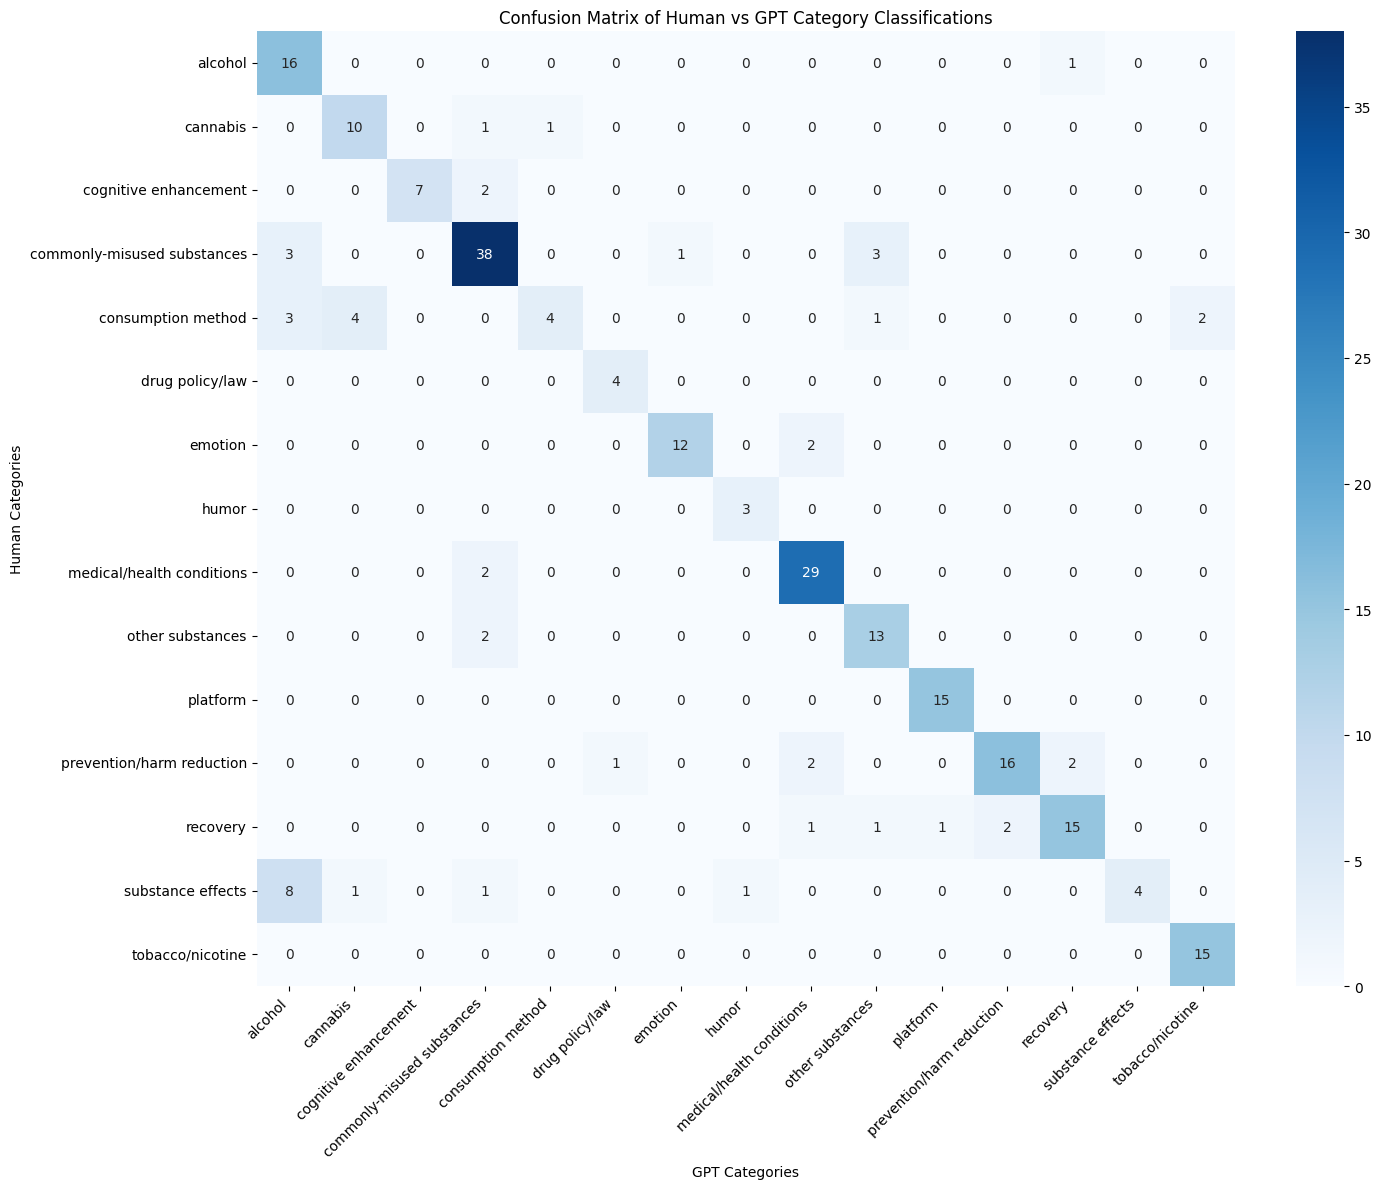

Confusion Matrix:
                             alcohol  cannabis  cognitive enhancement  \
alcohol                           16         0                      0   
cannabis                           0        10                      0   
cognitive enhancement              0         0                      7   
commonly-misused substances        3         0                      0   
consumption method                 3         4                      0   
drug policy/law                    0         0                      0   
emotion                            0         0                      0   
humor                              0         0                      0   
medical/health conditions          0         0                      0   
other substances                   0         0                      0   
platform                           0         0                      0   
prevention/harm reduction          0         0                      0   
recovery                         

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

# Load the datasets
human_df = pd.read_csv("human_hashtag_classifications.csv")
gpt_df = pd.read_csv("gpt_hashtag_classifications_4o.csv")

# Convert categories to lowercase for both DataFrames and replace NaN with a placeholder
human_df['category'] = human_df['category'].fillna('unknown').str.lower()
gpt_df['category'] = gpt_df['category'].fillna('unknown').str.lower()

# Apply the category mapping to the GPT DataFrame
category_mapping = {
    'platform engagement': 'platform',
    'commonly misused substances': 'commonly-misused substances'
}
gpt_df['category'] = gpt_df['category'].replace(category_mapping)

# Merge the datasets
merged_df = pd.merge(human_df, gpt_df, on='hashtag', how='left', suffixes=('_human', '_gpt'))

# Replace any remaining NaN values with 'unknown'
merged_df['category_human'] = merged_df['category_human'].fillna('unknown')
merged_df['category_gpt'] = merged_df['category_gpt'].fillna('unknown')

# Get all unique categories
all_categories = sorted(set(merged_df['category_human'].unique()) | set(merged_df['category_gpt'].unique()))

# Create the confusion matrix
cm = confusion_matrix(
    merged_df['category_human'],
    merged_df['category_gpt'],
    labels=all_categories
)

# Calculate overall accuracy
overall_accuracy = accuracy_score(merged_df['category_human'], merged_df['category_gpt'])

# Calculate accuracy for each category
category_accuracies = {}
for category in all_categories:
    category_mask = merged_df['category_human'] == category
    category_accuracy = accuracy_score(
        merged_df.loc[category_mask, 'category_human'],
        merged_df.loc[category_mask, 'category_gpt']
    )
    category_accuracies[category] = category_accuracy

# Create a heatmap of the confusion matrix
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=all_categories, yticklabels=all_categories)
plt.title('Confusion Matrix of Human vs GPT Category Classifications')
plt.xlabel('GPT Categories')
plt.ylabel('Human Categories')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print the confusion matrix
print("Confusion Matrix:")
print(pd.DataFrame(cm, index=all_categories, columns=all_categories))

# Print overall accuracy
print(f"\nOverall Accuracy: {overall_accuracy:.4f}")

# Print accuracy for each category
print("\nAccuracy by Category:")
for category, accuracy in sorted(category_accuracies.items(), key=lambda x: x[1], reverse=True):
    print(f"{category}: {accuracy:.4f}")

In [18]:
# Save the merged DataFrame to a CSV file
output_file = 'merged_hashtag_classifications_4o.csv'
merged_df.to_csv(output_file, index=False)
print(f"\nMerged dataset saved to {output_file}")


Merged dataset saved to merged_hashtag_classifications_4o.csv


In [11]:
print("Human categories:", sorted(human_df['category'].unique()))
print("GPT categories:", sorted(gpt_df['category'].unique()))

Human categories: ['alcohol', 'cannabis', 'cognitive enhancement', 'commonly-misused substances', 'consumption method', 'drug policy/law', 'emotion', 'humor', 'medical/health conditions', 'other substances', 'platform', 'prevention/harm reduction', 'recovery', 'substance effects', 'tobacco/nicotine']
GPT categories: ['alcohol', 'cannabis', 'cognitive enhancement', 'commonly-misused substances', 'consumption method', 'drug policy/law', 'emotion', 'humor', 'medical/health conditions', 'other substances', 'platform', 'prevention/harm reduction', 'recovery', 'substance effects', 'tobacco/nicotine']


In [13]:
human_categories = set(human_df['category'].str.lower())
gpt_categories = set(gpt_df['category'].str.lower())

print("Categories in human but not in GPT:", human_categories - gpt_categories)
print("Categories in GPT but not in human:", gpt_categories - human_categories)
print("Common categories:", human_categories.intersection(gpt_categories))

Categories in human but not in GPT: set()
Categories in GPT but not in human: set()
Common categories: {'substance effects', 'tobacco/nicotine', 'alcohol', 'emotion', 'cognitive enhancement', 'drug policy/law', 'cannabis', 'other substances', 'recovery', 'consumption method', 'commonly-misused substances', 'humor', 'prevention/harm reduction', 'platform', 'medical/health conditions'}


In [14]:
import pandas as pd

# Load the datasets
human_df = pd.read_csv("converted_Theme_and_Hashtag_Data_human.csv")
gpt_df = pd.read_csv("cleaned_categories.csv")

# Find the extra tag
extra_tag = set(human_df['Hashtag']) - set(gpt_df['Tag'])

if extra_tag:
    print(f"Extra tag in human dataset: {extra_tag}")
else:
    print("No extra tags found in the human dataset.")

# Merge the datasets
merged_df = pd.merge(human_df, gpt_df, left_on='Hashtag', right_on='Tag', how='left')

# Calculate accuracy
total_tags = len(merged_df)
matching_tags = (merged_df['Theme'] == merged_df['Category']).sum()
accuracy = matching_tags / total_tags

print(f"\nTotal tags: {total_tags}")
print(f"Matching tags: {matching_tags}")
print(f"Accuracy: {accuracy:.2%}")

# Save the merged dataset
merged_df.to_csv("merged_hashtag_categories.csv", index=False)
print("\nMerged dataset saved as 'merged_hashtag_categories.csv'")

# Display tags with mismatched categories
mismatched_tags = merged_df[merged_df['Theme'] != merged_df['Category']]
print("\nTags with mismatched categories:")
print(mismatched_tags[['Hashtag', 'Theme', 'Category']])

Extra tag in human dataset: {'na', 'naloxone', 'fypシ゚viral', 'fypシ'}

Total tags: 250
Matching tags: 0
Accuracy: 0.00%

Merged dataset saved as 'merged_hashtag_categories.csv'

Tags with mismatched categories:
            Hashtag             Theme  Category
0             funny             Humor       NaN
1    addictionhumor             Humor       NaN
2              meme             Humor       NaN
3              love           Emotion       NaN
4              pain           Emotion       NaN
..              ...               ...       ...
245         tobacco  tobacco/nicotine       NaN
246        nicotine  tobacco/nicotine       NaN
247    nicotinefein  tobacco/nicotine       NaN
248     nicotinegum  tobacco/nicotine       NaN
249  nicorettepatch  tobacco/nicotine       NaN

[250 rows x 3 columns]


In [65]:
import pandas as pd
import re

def parse_categorized_data(data):
    categories = {}
    current_category = None
    for line in data.split('\n'):
        line = line.strip()
        if re.match(r'\d+\.\s+\*\*.*\*\*:', line):
            current_category = re.search(r'\*\*(.*?)\*\*', line).group(1).strip()
            categories[current_category] = []
        elif line.startswith('- '):
            hashtag = line.strip('- ').strip()
            if current_category:
                categories[current_category].append(hashtag)
    return categories

def convert_to_csv_format(categorized_data, all_tags_string):
    categories = parse_categorized_data(categorized_data)
    
    # Get all tags from the original list
    all_tags = [tag.strip() for tag in all_tags_string.split('\n') if tag.strip()]
    
    df = pd.DataFrame(0, index=all_tags, columns=list(categories.keys()))
    
    for category, hashtags in categories.items():
        df.loc[df.index.isin(hashtags), category] = 1
    
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'Node'}, inplace=True)
    
    return df

# Assuming the categorized data is stored in the 'label' variable
# and all_tags is the string containing all tags

# Convert the categorized data to CSV format
result_df = convert_to_csv_format(label, all_tags)

# Save the result to a CSV file
output_file = 'categorized_hashtags_0815.csv'
result_df.to_csv(output_file, index=False)

print(f"Converted CSV saved to {output_file}")
print(f"Number of rows in output file: {len(result_df)}")
print(f"Number of columns in output file: {len(result_df.columns)}")

# Display the first few rows of the resulting DataFrame
print(result_df.head())

Converted CSV saved to categorized_hashtags_0815.csv
Number of rows in output file: 250
Number of columns in output file: 15
       Node  cannabis  platform engagement  cognitive enhancement  \
0       30s         0                    0                      0   
1       40s         0                    0                      0   
2  420vibes         1                    0                      0   
3      512s         0                    0                      0   
4      acid         0                    0                      0   

   tobacco/nicotine  drug policy/law  recovery  emotion/humor  \
0                 0                0         0              0   
1                 0                0         0              0   
2                 0                0         0              0   
3                 0                0         0              0   
4                 0                0         0              0   

   commonly misused substances  other substances  substance effects  

In [4]:
def convert_csv_format(input_file, output_file):
    # Read the input CSV file
    df = pd.read_csv(input_file)

    # Get categories (all column names)
    categories = df.columns.tolist()

    # Get all unique hashtags from all columns
    all_hashtags = set()
    for category in categories:
        all_hashtags.update(df[category].dropna())
    all_hashtags = sorted(list(all_hashtags))

    print(f"Number of unique hashtags: {len(all_hashtags)}")

    # Create a new DataFrame with hashtags as index and categories as columns
    new_df = pd.DataFrame(index=all_hashtags, columns=categories)

    # Fill the new DataFrame with 1s and 0s
    for category in categories:
        category_hashtags = set(df[category].dropna())
        new_df[category] = new_df.index.isin(category_hashtags).astype(int)

    # Reset index to make hashtags a column
    new_df.reset_index(inplace=True)
    new_df.rename(columns={'index': 'Node'}, inplace=True)

    # Save the new DataFrame to a CSV file
    new_df.to_csv(output_file, index=False)

    print(f"Converted CSV saved to {output_file}")
    print(f"Number of rows in output file: {len(new_df)}")
    print(f"Number of columns in output file: {len(new_df.columns)}")

# Example usage
input_file = 'community_grouping_gpt.csv'
output_file = 'gpt_grouping.csv'
convert_csv_format(input_file, output_file)

Number of unique hashtags: 209
Converted CSV saved to gpt_grouping.csv
Number of rows in output file: 209
Number of columns in output file: 15


In [45]:
# used chatgpt to convert the string output above to community_grouping_gpt.csv and reformat the original seed hashtag csv
human = pd.read_csv("converted_grouping_format.csv")
gpt = pd.read_csv("categorized_hashtags_0815.csv")

In [51]:
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score

# Load the datasets
human = pd.read_csv("converted_grouping_format.csv")
gpt = pd.read_csv("categorized_hashtags_0815.csv")

# Ensure column names are lowercase and sorted
human.columns = human.columns.str.lower()
gpt.columns = gpt.columns.str.lower()
human = human.reindex(sorted(human.columns), axis=1)
gpt = gpt.reindex(sorted(gpt.columns), axis=1)

# Function to calculate Cohen's Kappa and IRR for each category
def calculate_metrics(human_df, gpt_df):
    results = []
    for col in human_df.columns:
        if col in gpt_df.columns and col != 'node':
            human_values = human_df[col].values
            gpt_values = gpt_df[col].values
            
            # Calculate Cohen's Kappa
            kappa = cohen_kappa_score(human_values, gpt_values)
            
            # Calculate IRR (simple agreement)
            accuracy = np.mean(human_values == gpt_values)
            
            results.append({
                "Category": col,
                "Cohen_Kappa": kappa,
                "Accuracy": accuracy
            })
    
    return pd.DataFrame(results)

# Calculate metrics
metrics = calculate_metrics(human, gpt)

# Sort results by Cohen's Kappa
metrics_sorted = metrics.sort_values("Cohen_Kappa", ascending=False)

# Display results
print("Metrics by Category:")
print(metrics_sorted)

# Calculate overall metrics
all_human_values = human.drop(columns=['node']).values.flatten()
all_gpt_values = gpt.drop(columns=['node']).values.flatten()

overall_kappa = cohen_kappa_score(all_human_values, all_gpt_values)
overall_irr = np.mean(all_human_values == all_gpt_values)

print(f"\nOverall Cohen's Kappa: {overall_kappa}")
print(f"Overall Accuracy: {overall_irr}")

Metrics by Category:
                       Category  Cohen_Kappa  Accuracy
12            substance effects     0.924357     0.992
13             tobacco/nicotine     0.890190     0.988
2         cognitive enhancement     0.870934     0.992
7     medical/health conditions     0.799197     0.960
8              other substances     0.759285     0.972
0                       alcohol     0.716634     0.968
1                      cannabis     0.688020     0.976
5               drug policy/law     0.663073     0.992
10    prevention/harm reduction     0.663073     0.956
9                      platform     0.651811     0.968
11                     recovery     0.647887     0.960
4            consumption method     0.594419     0.960
3   commonly-misused substances     0.542993     0.892
6                       emotion     0.371016     0.940

Overall Cohen's Kappa: 0.6961979913916786
Overall Accuracy: 0.9654285714285714


In [50]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

# Load the datasets
human = pd.read_csv("converted_grouping_format.csv")
gpt = pd.read_csv("categorized_hashtags_0815.csv")

# Ensure column names are lowercase and sorted
human.columns = human.columns.str.lower()
gpt.columns = gpt.columns.str.lower()
human = human.reindex(sorted(human.columns), axis=1)
gpt = gpt.reindex(sorted(gpt.columns), axis=1)

# Function to calculate confusion matrix and accuracy for each category
def calculate_metrics(human_df, gpt_df):
    results = []
    for col in human_df.columns:
        if col in gpt_df.columns and col != 'node':
            human_values = human_df[col].values
            gpt_values = gpt_df[col].values
            
            # Calculate confusion matrix
            cm = confusion_matrix(human_values, gpt_values)
            
            # Calculate accuracy
            acc = accuracy_score(human_values, gpt_values)
            
            results.append({
                "Category": col,
                "Confusion_Matrix": cm,
                "Accuracy": acc
            })
    
    return results

# Calculate metrics
metrics = calculate_metrics(human, gpt)

# Display results
for result in metrics:
    print(f"\nCategory: {result['Category']}")
    print(f"Accuracy: {result['Accuracy']:.4f}")
    print("Confusion Matrix:")
    cm = result['Confusion_Matrix']
    print(f"    GPT")
    print(f"      0     1")
    print(f"H 0 [{cm[0][0]:4d} {cm[0][1]:4d}]")
    print(f"U 1 [{cm[1][0]:4d} {cm[1][1]:4d}]")

# Calculate overall accuracy
all_human_values = human.drop(columns=['node']).values.flatten()
all_gpt_values = gpt.drop(columns=['node']).values.flatten()
overall_accuracy = accuracy_score(all_human_values, all_gpt_values)

print(f"\nOverall Accuracy: {overall_accuracy:.4f}")

# Calculate overall confusion matrix
overall_cm = confusion_matrix(all_human_values, all_gpt_values)
print("\nOverall Confusion Matrix:")
print(f"    GPT")
print(f"      0     1")
print(f"H 0 [{overall_cm[0][0]:4d} {overall_cm[0][1]:4d}]")
print(f"U 1 [{overall_cm[1][0]:4d} {overall_cm[1][1]:4d}]")


Category: alcohol
Accuracy: 0.9680
Confusion Matrix:
    GPT
      0     1
H 0 [ 231    2]
U 1 [   6   11]

Category: cannabis
Accuracy: 0.9760
Confusion Matrix:
    GPT
      0     1
H 0 [ 237    1]
U 1 [   5    7]

Category: cognitive enhancement
Accuracy: 0.9920
Confusion Matrix:
    GPT
      0     1
H 0 [ 241    0]
U 1 [   2    7]

Category: commonly-misused substances
Accuracy: 0.8920
Confusion Matrix:
    GPT
      0     1
H 0 [ 203    2]
U 1 [  25   20]

Category: consumption method
Accuracy: 0.9600
Confusion Matrix:
    GPT
      0     1
H 0 [ 232    4]
U 1 [   6    8]

Category: drug policy/law
Accuracy: 0.9920
Confusion Matrix:
    GPT
      0     1
H 0 [ 246    0]
U 1 [   2    2]

Category: emotion
Accuracy: 0.9400
Confusion Matrix:
    GPT
      0     1
H 0 [ 230    4]
U 1 [  11    5]

Category: medical/health conditions
Accuracy: 0.9600
Confusion Matrix:
    GPT
      0     1
H 0 [ 217    2]
U 1 [   8   23]

Category: other substances
Accuracy: 0.9720
Confusion Matrix:
 

In [53]:
import re

def parse_and_print_categories(data):
    categories = {}
    current_category = None
    
    for line in data.split('\n'):
        line = line.strip()
        if re.match(r'\d+\.\s+\*\*.*\*\*:', line):
            current_category = re.search(r'\*\*(.*?)\*\*', line).group(1).strip()
            categories[current_category] = []
        elif line.startswith('- '):
            hashtag = line.strip('- ').strip()
            if current_category:
                categories[current_category].append(hashtag)
    
    # Print the parsed data
    for category, hashtags in categories.items():
        print(f"\n{category}:")
        for hashtag in sorted(hashtags):
            print(f"   {hashtag}")

# Assuming the categorized data is stored in the 'label' variable
parse_and_print_categories(label)


cannabis:
   420vibes
   cannabis
   keepsmokingtheherb
   pot
   shmeeds
   stonersoftiktok
   stonervibes
   weed

platform engagement:
   foryou
   foryoupage
   foryourpage
   fyp
   fyp„ç∑
   fyp„ç∑„çöviral
   tiktok
   trending
   viral
   xyzbca

cognitive enhancement:
   adderral
   cognitiveenhancers
   modafinil
   nootropics
   nootrostatic
   smartdrugs
   smartpills

tobacco/nicotine:
   cig
   cigarette
   cigarettes
   ecig
   ecigs
   juul
   nicorettepatch
   nicotine
   nicotinefein
   nicotinegum
   smoking
   vape
   vaper
   vaping

drug policy/law:
   druglaws
   drugpolicy

recovery:
   cleanandsober
   drugrehab
   recovery
   sober
   soberhouse
   soberlife
   soberliving
   sobriety
   sobrietybirthday
   wedorecover

emotion/humor:
   addictionhumor
   funny
   happy
   happytobealive
   makesomeonesmile
   meme
   shmoke
   shmokesumthin
   shmoketok

commonly misused substances:
   balloons
   c0deine
   fent
   fentfriday
   heroin
   inhalants
   inhala

In [57]:
import pandas as pd

# Load the datasets
human = pd.read_csv("converted_grouping_format.csv")
gpt = pd.read_csv("categorized_hashtags_0815.csv")

# Ensure column names are lowercase and sorted
human.columns = human.columns.str.lower()
gpt.columns = gpt.columns.str.lower()
human = human.reindex(sorted(human.columns), axis=1)
gpt = gpt.reindex(sorted(gpt.columns), axis=1)

# Function to get hashtags for a category
def get_hashtags(df, category, limit=10):
    tags = sorted(df[df[category] == 1]['node'])
    return tags[:limit]

# Function to format tags
def format_tags(tags):
    return '\n'.join(f"- {tag}" for tag in tags)

# Compare hashtags for each category
comparison = []
for category in human.columns:
    if category != 'node':
        human_tags = get_hashtags(human, category)
        gpt_tags = get_hashtags(gpt, category)
        
        comparison.append({
            'Category': category,
            'Human Tags': format_tags(human_tags),
            'GPT Tags': format_tags(gpt_tags)
        })

# Print the comparison
for item in comparison:
    print(f"\n{'=' * 80}")
    print(f"Category: {item['Category']}")
    print(f"{'-' * 80}")
    print("Human Tags:                 GPT Tags:")
    print(f"{'-' * 80}")
    human_lines = item['Human Tags'].split('\n')
    gpt_lines = item['GPT Tags'].split('\n')
    max_lines = max(len(human_lines), len(gpt_lines))
    for i in range(max_lines):
        human_tag = human_lines[i] if i < len(human_lines) else ''
        gpt_tag = gpt_lines[i] if i < len(gpt_lines) else ''
        print(f"{human_tag:<30} {gpt_tag}")


Category: alcohol
--------------------------------------------------------------------------------
Human Tags:                 GPT Tags:
--------------------------------------------------------------------------------
- alchohol                     - alcohol
- alcohol                      - alcoholfreejourney
- alcoholfreejourney           - alcoholic
- alcoholic                    - alcoholism
- alcoholism                   - beers
- beerfunnel                   - booze
- beers                        - cocktails
- booze                        - drunk
- chugbeer                     - hammered
- cocktails                    - liquor

Category: cannabis
--------------------------------------------------------------------------------
Human Tags:                 GPT Tags:
--------------------------------------------------------------------------------
- 420vibes                     - 420vibes
- cannabis                     - cannabis
- dabs                         - keepsmokingtheherb
- g

In [48]:
from sklearn.metrics import cohen_kappa_score
import pandas as pd

# Lowercase columns
human.columns = human.columns.str.lower()
gpt.columns = gpt.columns.str.lower()

# Sort columns alphabetically
human = human.reindex(sorted(human.columns), axis=1)
gpt = gpt.reindex(sorted(gpt.columns), axis=1)

# Initialize a list to store the results
kappa_results = []

# Calculate Cohen's Kappa for each pair of columns
for col in human.columns:
    if col in gpt.columns:
        # Extract the entire columns
        human_labels = human[col].dropna()
        gpt_labels = gpt[col].dropna()
        
        # Find the common indices
        common_indices = human_labels.index.intersection(gpt_labels.index)
        
        # Align the labels using common indices
        human_aligned = human_labels.loc[common_indices]
        gpt_aligned = gpt_labels.loc[common_indices]
        
        # Calculate Cohen's Kappa
        kappa_score = cohen_kappa_score(human_aligned, gpt_aligned)
        
        # Append the results to the list
        kappa_results.append({
            "Theme": col,
            "Cohen_Kappa": kappa_score,
            "Sample_Size": len(common_indices)
        })
    else:
        print(f"Skipping column: {col} as it's not present in both datasets.")

# Convert the results to a DataFrame for better readability
df_kappa = pd.DataFrame(kappa_results)

# Sort the results by Cohen's Kappa score in descending order
df_kappa = df_kappa.sort_values("Cohen_Kappa", ascending=False)

# Display the results
print(df_kappa)

                          Theme  Cohen_Kappa  Sample_Size
8                          node     0.991968          250
13            substance effects     0.924357          250
14             tobacco/nicotine     0.890190          250
2         cognitive enhancement     0.870934          250
7     medical/health conditions     0.799197          250
9              other substances     0.759285          250
0                       alcohol     0.716634          250
1                      cannabis     0.688020          250
5               drug policy/law     0.663073          250
11    prevention/harm reduction     0.663073          250
10                     platform     0.651811          250
12                     recovery     0.647887          250
4            consumption method     0.594419          250
3   commonly-misused substances     0.542993          250
6                       emotion     0.371016          250


In [49]:
from sklearn.metrics import cohen_kappa_score

# lowercase cols
human.columns = human.columns.str.lower()
gpt.columns = gpt.columns.str.lower()
# print(human.columns)
# print(gpt.columns)

# Sort columns alphabetically
human = human.reindex(sorted(human.columns), axis=1)
gpt = gpt.reindex(sorted(gpt.columns), axis=1)
# Calculate Cohen's Kappa for each pair of columns
kappa_results = []


# Calculate Cohen's Kappa for each pair of columns
for human_col, gpt_col in zip(human.columns, gpt.columns):
    # print(human_col, gpt_col)
    # Check if the columns are the same
    if human_col == gpt_col:
        
        # Ensure the two columns are compared row by row as individual labels
        human_labels = human[human_col].dropna()
        gpt_labels = gpt[gpt_col].dropna()
        # Find the indices where both human and GPT have labels
        common_indices = human_labels.index.intersection(gpt_labels.index)
        # Calculate Cohen's Kappa
        kappa_score = cohen_kappa_score(human_labels.loc[common_indices], gpt_labels.loc[common_indices])
        
        # Append the results to the list
        kappa_results.append({
            "Theme": human_col,
            "Cohen_Kappa": kappa_score
        })
    else:
        print(f"Skipping columns: {human_col} and {gpt_col} as they do not match.")

# Convert the results to a DataFrame for better readability
df_kappa = pd.DataFrame(kappa_results)

# Display the results
print(df_kappa)


                          Theme  Cohen_Kappa
0                       alcohol     0.716634
1                      cannabis     0.688020
2         cognitive enhancement     0.870934
3   commonly-misused substances     0.542993
4            consumption method     0.594419
5               drug policy/law     0.663073
6                       emotion     0.371016
7     medical/health conditions     0.799197
8                          node     0.991968
9              other substances     0.759285
10                     platform     0.651811
11    prevention/harm reduction     0.663073
12                     recovery     0.647887
13            substance effects     0.924357
14             tobacco/nicotine     0.890190
